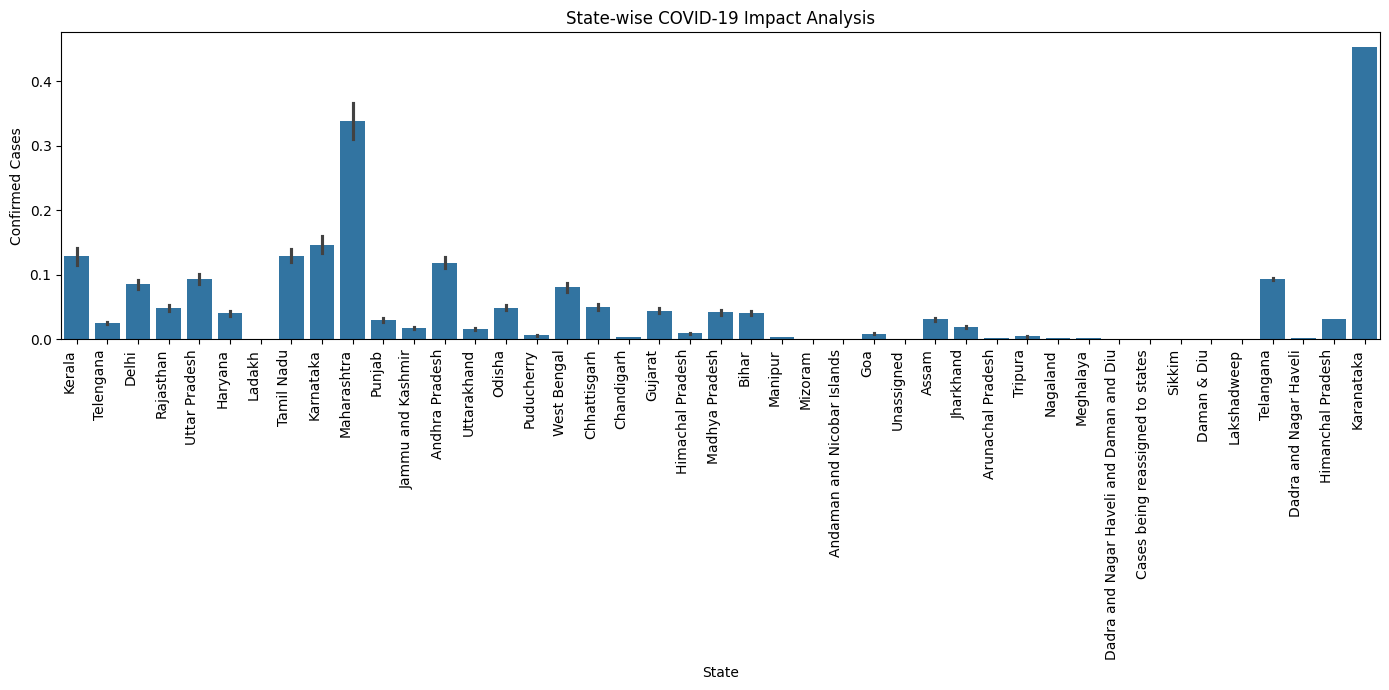

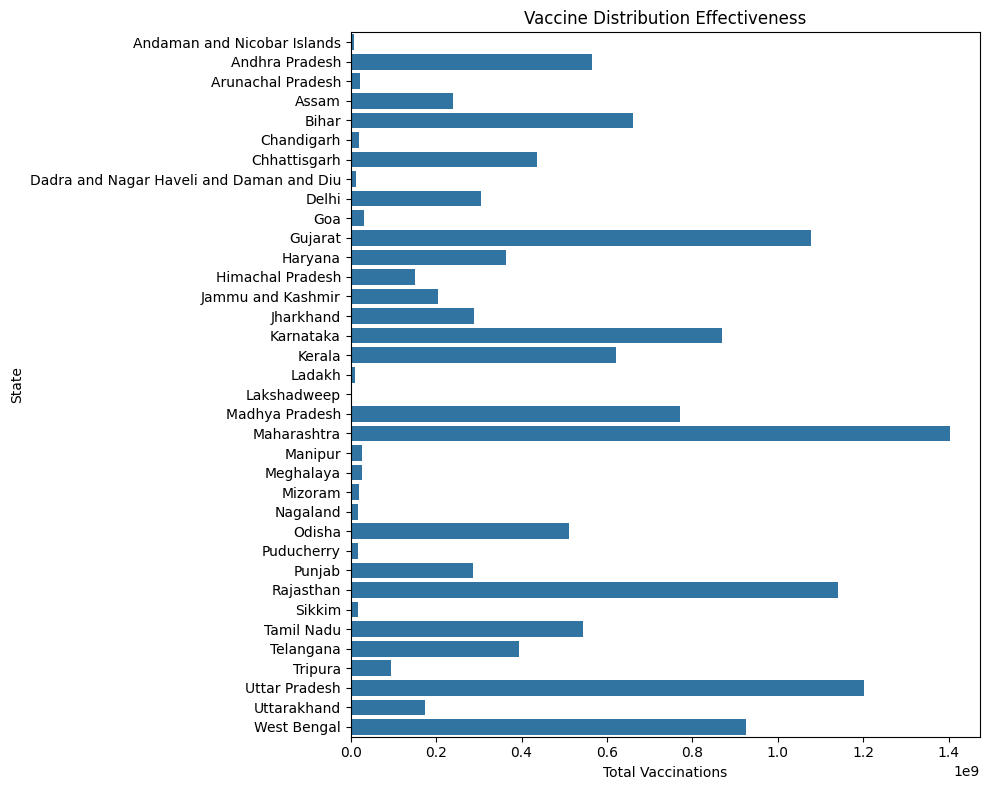

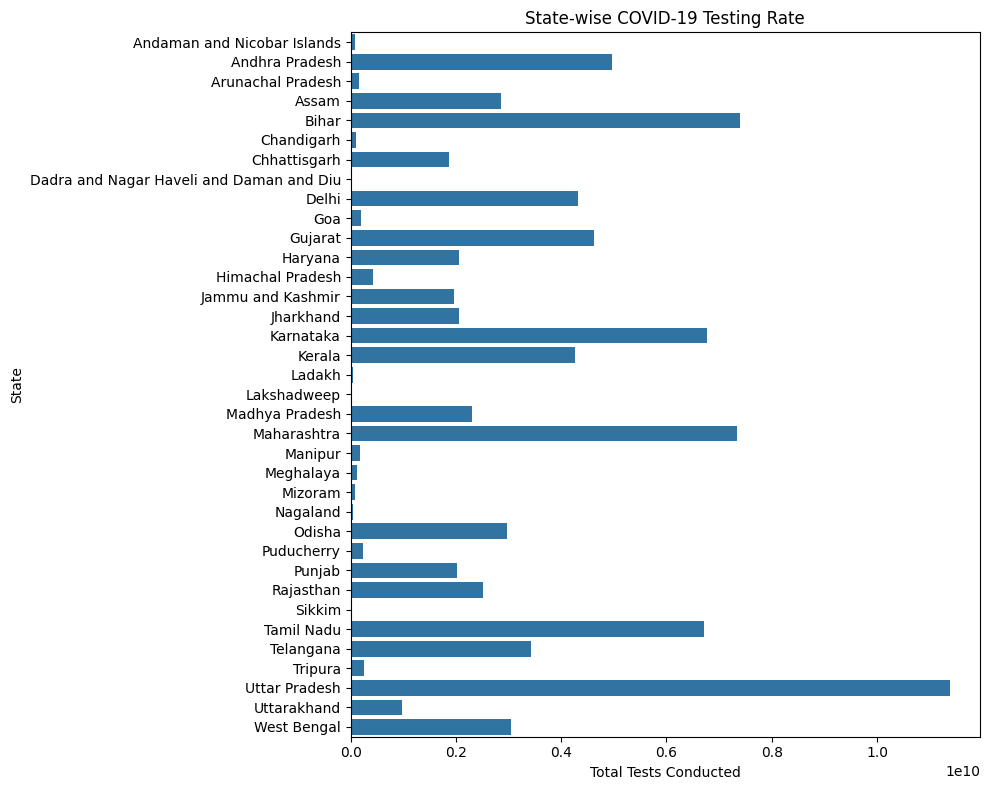

Mean Absolute Error: 0.0002415893621108608
Mean Squared Error: 1.333955692073384e-06
R-Squared Score: 0.9998824626861057


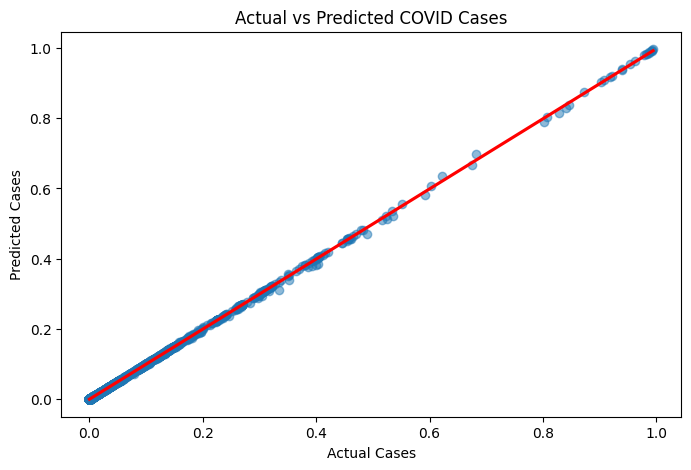

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load datasets
testing_details = pd.read_csv(r"C:\Users\Hp\OneDrive\Desktop\DATASET\StatewiseTestingDetails.csv")
covid_cases = pd.read_csv(r"C:\Users\Hp\OneDrive\Desktop\DATASET\covid_19_india.csv")
vaccine_data = pd.read_csv(r"C:\Users\Hp\OneDrive\Desktop\DATASET\covid_vaccine_statewise.csv")

# Convert date columns
testing_details["Date"] = pd.to_datetime(testing_details["Date"], format="%d/%m/%Y", errors="coerce")
covid_cases["Date"] = pd.to_datetime(covid_cases["Date"], format="%d/%m/%Y", errors="coerce")
vaccine_data.rename(columns={"Updated On": "Date"}, inplace=True)
vaccine_data["Date"] = pd.to_datetime(vaccine_data["Date"], format="%d/%m/%Y", errors="coerce")

# Handle missing values correctly
for df in [testing_details, covid_cases, vaccine_data]:
    for col in df.select_dtypes(include=['datetime64']):
        df[col] = df[col].fillna(pd.NaT)  # Fill missing dates with NaT
    for col in df.select_dtypes(exclude=['datetime64']):
        df[col] = df[col].fillna(0)  # Fill other missing values with 0

# Convert problematic columns to numeric
testing_details["Negative"] = pd.to_numeric(testing_details["Negative"], errors="coerce").fillna(0)
covid_cases["ConfirmedIndianNational"] = pd.to_numeric(covid_cases["ConfirmedIndianNational"], errors="coerce").fillna(0)
covid_cases["ConfirmedForeignNational"] = pd.to_numeric(covid_cases["ConfirmedForeignNational"], errors="coerce").fillna(0)

# Feature Engineering
covid_cases['Positivity_Rate'] = covid_cases['Confirmed'] / (testing_details['TotalSamples'] + 1)
covid_cases['Recovery_Rate'] = covid_cases['Cured'] / (covid_cases['Confirmed'] + 1)
covid_cases['Fatality_Rate'] = covid_cases['Deaths'] / (covid_cases['Confirmed'] + 1)

# Feature Scaling
scaler = MinMaxScaler()
covid_cases[['Confirmed', 'Cured', 'Deaths']] = scaler.fit_transform(covid_cases[['Confirmed', 'Cured', 'Deaths']])

# State-wise COVID-19 Impact Analysis
covid_cases_filtered = covid_cases[~covid_cases['State/UnionTerritory'].str.contains(r'\*+', regex=True)]
covid_cases_filtered = covid_cases_filtered[covid_cases_filtered['State/UnionTerritory'] != 'India']
plt.figure(figsize=(14, 7))
sns.barplot(x=covid_cases_filtered['State/UnionTerritory'], y=covid_cases_filtered['Confirmed'])
plt.xticks(rotation=90, ha='right')
plt.xlabel("State")
plt.ylabel("Confirmed Cases")
plt.title("State-wise COVID-19 Impact Analysis")
plt.tight_layout()
plt.show()

# Vaccine Distribution Effectiveness using a horizontal bar chart
vaccine_distribution = vaccine_data.groupby('State')['Total Individuals Vaccinated'].sum().reset_index()
vaccine_distribution = vaccine_distribution[~vaccine_distribution['State'].str.contains(r'\*+', regex=True)]
vaccine_distribution = vaccine_distribution[vaccine_distribution['State'] != 'India']
plt.figure(figsize=(10, 8))
sns.barplot(y=vaccine_distribution['State'], x=vaccine_distribution['Total Individuals Vaccinated'])
plt.xlabel("Total Vaccinations")
plt.ylabel("State")
plt.title("Vaccine Distribution Effectiveness")
plt.tight_layout()
plt.show()

# Testing Rate Analysis
testing_rate = testing_details.groupby('State')['TotalSamples'].sum().reset_index()
testing_rate = testing_rate[~testing_rate['State'].str.contains(r'\*+', regex=True)]
testing_rate = testing_rate[testing_rate['State'] != 'India']
plt.figure(figsize=(10, 8))
sns.barplot(y=testing_rate['State'], x=testing_rate['TotalSamples'])
plt.xlabel("Total Tests Conducted")
plt.ylabel("State")
plt.title("State-wise COVID-19 Testing Rate")
plt.tight_layout()
plt.show()

# Selecting Features & Target Variable (excluding 'State/UnionTerritory')
X = covid_cases[['Cured', 'Deaths', 'Positivity_Rate', 'Recovery_Rate', 'Fatality_Rate']]
y = covid_cases['Confirmed']

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-Squared Score: {r2}")

# Visualizing Predictions vs Actuals
plt.figure(figsize=(8,5))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.xlabel("Actual Cases")
plt.ylabel("Predicted Cases")
plt.title("Actual vs Predicted COVID Cases")
plt.show()
